# ZNEUS - Project 2

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import torch.nn as nn
from PIL import Image

DATA = "data\\raw-img"
METAS = "data\\metas.csv"
RESIZED_DIR = "data\\resized_images"
os.makedirs(RESIZED_DIR, exist_ok=True)
IS_FULL_EXECUTE = False
R_SEED = 42

#model parameters - initial configuration
EPOCH = 50
BATCH_SIZE = 128
LR = 0.001

#check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
translations = {"cane": "dog", "ragno": "spider", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}

The translation was missing a mapping for 'rango' -> 'spider', the english -> italian was present

## 1. EDA
### 1.1 Load dataset

In [3]:
def scan_images(root_folder: str) -> pd.DataFrame: #extract image info from files
    records = []

    for dirpath, _, filenames in os.walk(root_folder):
        for fname in filenames:
            file_path = os.path.join(dirpath, fname)
            ext = os.path.splitext(fname)[1].lower()

            img = cv2.imread(file_path)
            if img is None:
                print(f"Skipping invalid or missing image: {file_path}")
                continue #skip corrupted files

            height, width, num_channels = img.shape
            records.append({
                "folder": os.path.basename(dirpath),
                "file_path": file_path,
                "extension": ext,
                "width": width,
                "height": height,
                "num_channels": num_channels
            })

    return pd.DataFrame(records)

In [4]:
if IS_FULL_EXECUTE:
    #go through all files and create a csv file with all the info, paths and parameters for further use
    df = scan_images(DATA)
    assert df["file_path"].is_unique
    df["label"] = df["folder"].map(translations)
    df.to_csv(METAS)
else:
    #if it has already been done, we just read the csv
    df = pd.read_csv(METAS)

### 1.2 Duplicates

In [10]:
df.duplicated("file_path").sum()

np.int64(0)

There are no duplicate images.


### 1.3 Missing data

In [11]:
df.isna().sum(axis=0)

folder          0
file_path       0
extension       0
width           0
height          0
num_channels    0
label           0
dtype: int64

No missing values after translation dictionary correction

### 1.4 Info about dataset

In [12]:
df.head()

,folder,file_path,extension,width,height,num_channels,label
0,cane,data\raw-img\cane\OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,.jpeg,300.0,225.0,3.0,dog
1,cane,data\raw-img\cane\OIP---A27bIBcUgX1qkbpZOPswHa...,.jpeg,300.0,214.0,3.0,dog
2,cane,data\raw-img\cane\OIP---cByAiEbIxIAleGo9AqOQAA...,.jpeg,153.0,300.0,3.0,dog
3,cane,data\raw-img\cane\OIP---ZIdwfUcJeVxnh47zppcQHa...,.jpeg,300.0,225.0,3.0,dog
4,cane,data\raw-img\cane\OIP---ZRsOF7zsMqhW30WeF8-AHa...,.jpeg,300.0,225.0,3.0,dog


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   folder        26179 non-null  object 
 1   file_path     26179 non-null  object 
 2   extension     26179 non-null  object 
 3   width         26179 non-null  float64
 4   height        26179 non-null  float64
 5   num_channels  26179 non-null  float64
 6   label         26179 non-null  object 
dtypes: float64(3), object(4)
memory usage: 1.4+ MB


In our dataset we have 26179 entries and 7 columns, label is the target column.

#### Image ratio
Lets add column Image ratio to illustrate the ratio of width and height so we can filter images that are too "wide" or too "high".

In [14]:
df["ratio"] = (df["width"] / df["height"]).round(3)
df["ratio"].value_counts().nlargest(10).sort_values(ascending=False)

ratio
1.333    4591
1.500    3322
1.000    1279
1.775    1049
1.502     694
1.508     592
0.750     524
1.250     419
1.596     395
0.667     373
Name: count, dtype: int64

Images have very different proportions, the most common are 1.33 and 1.5.


### 1.5 Outliers in width, height, ratio

In [54]:
df.describe()

,width,height,num_channels,ration,ratio
count,26179.000000,26179.000000,26179.0,26179.000000,26179.000000
mean,320.038810,252.630162,3.0,1.311318,1.311318
std,196.935326,148.403298,0.0,0.311223,0.311223
min,60.000000,57.000000,3.0,0.293000,0.293000
25%,300.000000,200.000000,3.0,1.136000,1.136000
50%,300.000000,225.000000,3.0,1.333000,1.333000
75%,300.000000,300.000000,3.0,1.500000,1.500000
max,6720.000000,6000.000000,3.0,4.225000,4.225000


We can see, that some images are very large (width = 6720 or height = 6000) or some images have ratios > 4, these images are outliers.

### Find outliers

In [17]:
#lets say that we want only pictures in sizes of (50,1000) and ratio would be (0.3,3)
min_width, max_width = 50, 1000
min_height, max_height = 50, 1000
min_ratio, max_ratio = 0.3, 3

def check_outliers(df):
    #finding outliers
    outlier_width = df[(df['width'] < min_width) | (df['width'] > max_width)]
    outlier_height = df[(df['height'] < min_height) | (df['height'] > max_height)]
    outlier_ratio = df[(df['ratio'] < min_ratio) | (df['ratio'] > max_ratio)]    

    print(f"Number of width outliers: {len(outlier_width)}")
    print(f"Number of height outliers: {len(outlier_height)}")
    print(f"Number of ratio outliers: {len(outlier_ratio)}\n")

check_outliers(df)

#remove outliers
df = df[
    (df['width'] >= min_width) & (df['width'] <= max_width) &
    (df['height'] >= min_height) & (df['height'] <= max_height) &
    (df['ratio'] >= min_ratio) & (df['ratio'] <= max_ratio)
]

check_outliers(df)

Number of width outliers: 42
Number of height outliers: 42
Number of ratio outliers: 8

Number of width outliers: 0
Number of height outliers: 0
Number of ratio outliers: 0



### 1.6 Visualize data

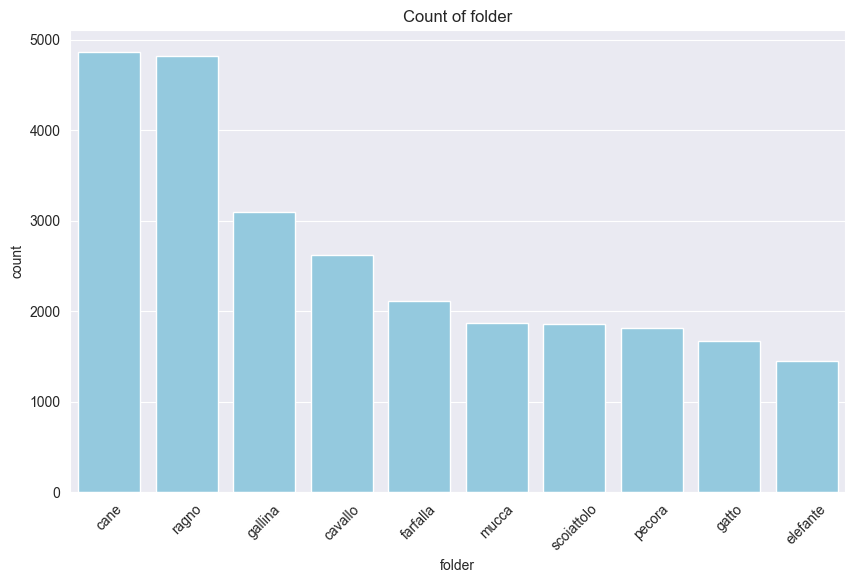

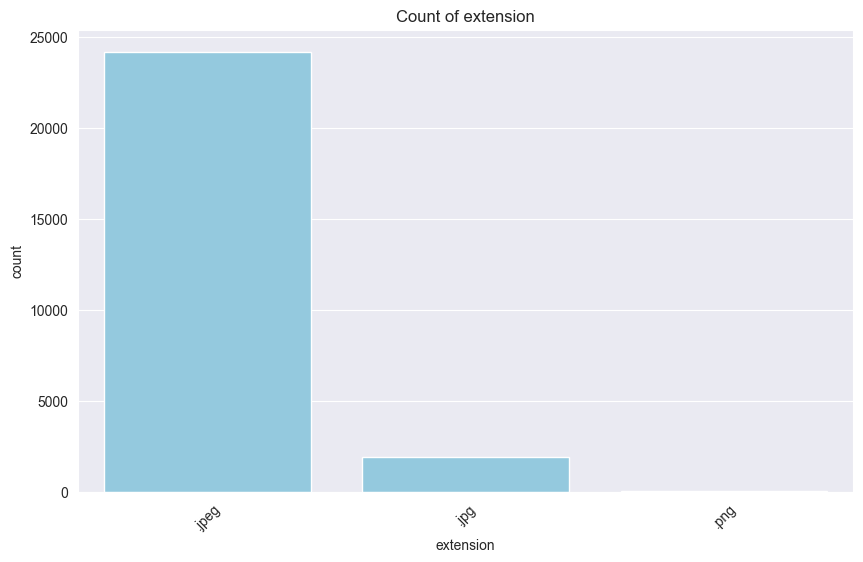

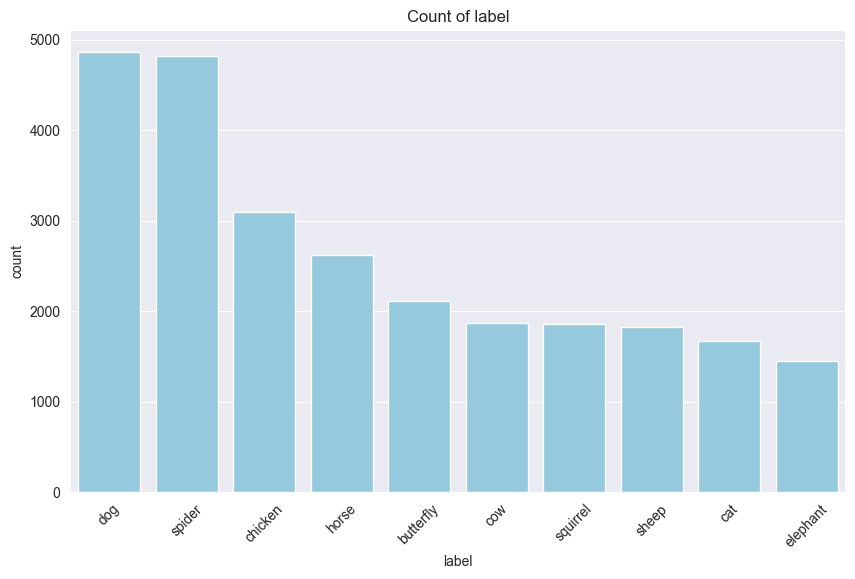

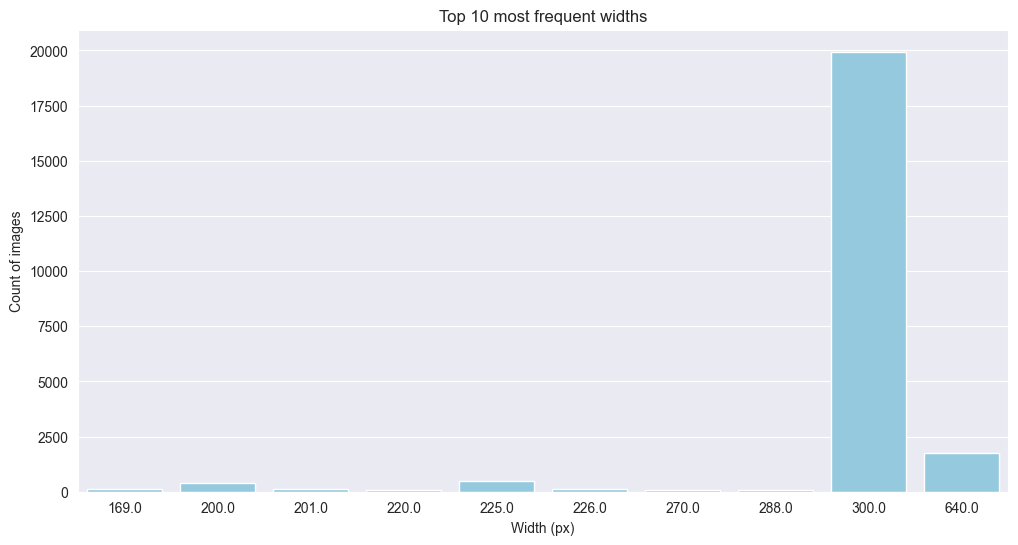

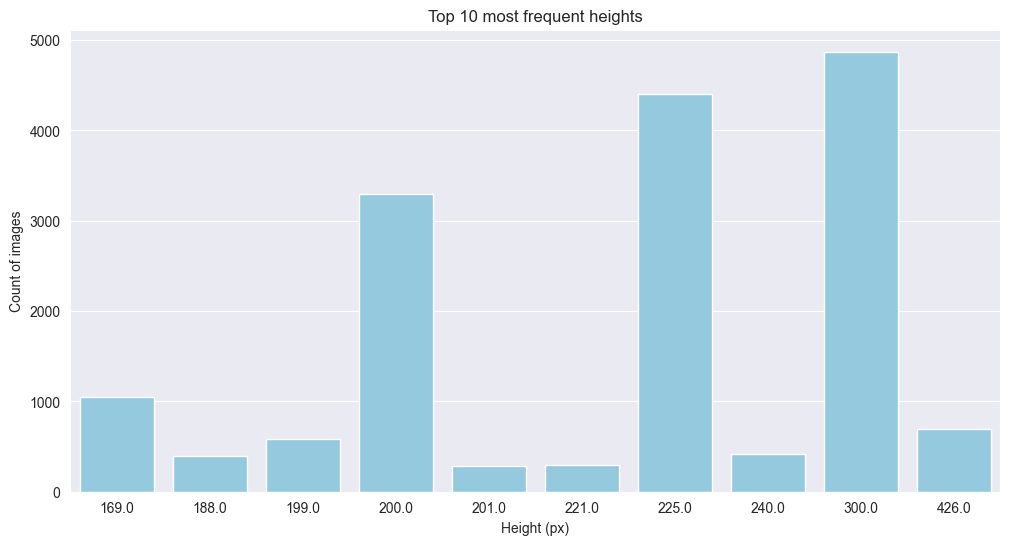

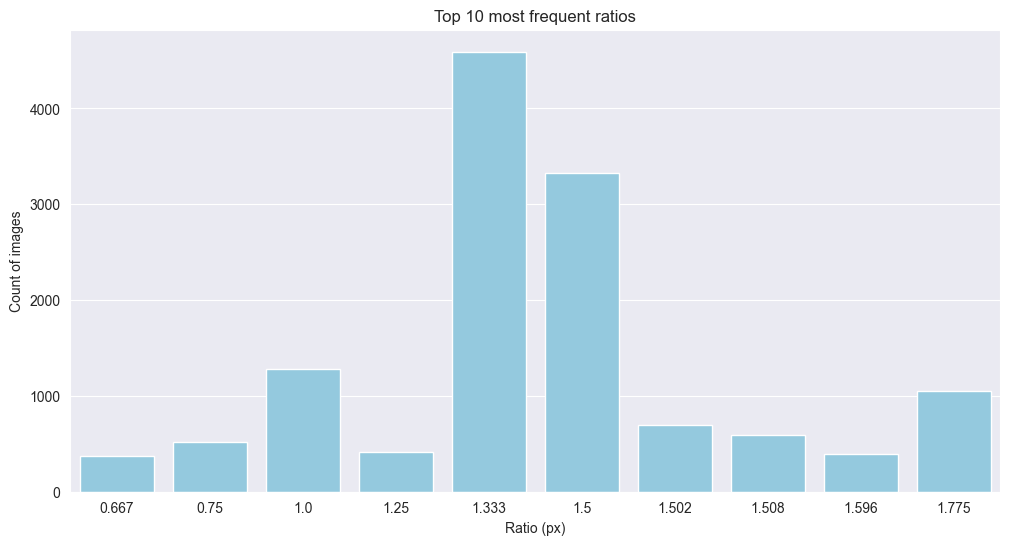

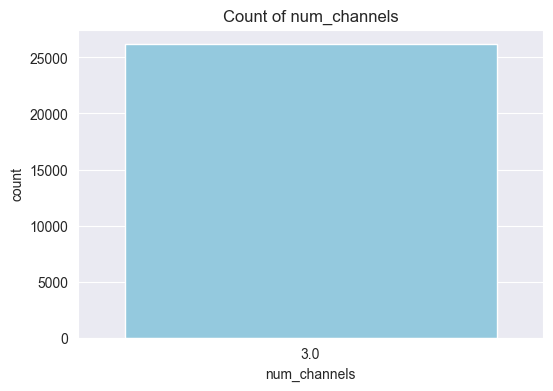

In [15]:
cat_cols = ["folder", "extension", "label"]
num_cols = ["width", "height", "num_channels"]
top_ten_cols = ["width", "height", "ratio"]

#draw categorical columns
for col in cat_cols:
    plt.figure(figsize=(10,6))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index, color="skyblue")
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.show()
    
#draw top-ten most common valeus columns
for col in top_ten_cols:
    top_counts = df[col].value_counts().nlargest(10).sort_index()  #10 most common values
    plt.figure(figsize=(12,6))
    sns.barplot(x=top_counts.index, y=top_counts.values, color='skyblue')
    plt.title(f"Top 10 most frequent {col}s")
    plt.xlabel(f"{col.capitalize()} (px)")
    plt.ylabel("Count of images")
    plt.show()
    
#draw num_of_channels
plt.figure(figsize=(6,4))
sns.countplot(x=df["num_channels"], data=df, color="skyblue")
plt.title("Count of num_channels")
plt.show()

- We can see, that almost half of all the pictures are dogs and spiders.
- All the images use 3 channels.
- .jpeg is the most common, yet they all are using 3-channels, and cv2 can work with all of them so there is no need for convertion
- Almost all of the widths are values: 300 and 640
- Heights are more varied, most common are: 300, 225, 200 and 169

### 1.7 Evaluation metrics

For evaluation we will use Cross Entropy Loss (classification).

## 2. Preprocessing
### 2.1 Resize images

In [61]:
TARGET_SIZE = (128,128) #we will resize all images to 128x128

def is_resized_done(resized_dir, labels): #if we already resized the images
    if not os.path.exists(resized_dir):
        return False
    #if the subfolders are there too
    for label in labels:
        label_path = os.path.join(resized_dir, label)
        if not os.path.exists(label_path) or len(os.listdir(label_path)) == 0:
            return False
    return True


if is_resized_done(RESIZED_DIR, df['label'].unique()):
    print("Resized images already exist. Skipping resize.")
else:
    print("Resizing images...")
    #create subfolders from labels
    for label in df['label'].unique():
        os.makedirs(os.path.join(RESIZED_DIR, label), exist_ok=True)

    #resize and save files
    for idx, row in df.iterrows():
        img_path = row['file_path']
        label = row['label']
        save_path = os.path.join(RESIZED_DIR, label, os.path.basename(img_path))
        img = Image.open(img_path).convert("RGB")
        img_resized = img.resize(TARGET_SIZE)
        img_resized.save(save_path)

    print("All images resized and saved.")


Resizing images...
All images resized and saved.


### 2.2 Split dataset

In [18]:
#70% train, 15% val, 15% test
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=R_SEED)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=R_SEED)

Stratify will keep the class ratios from the original dataset so in the split, all classes are represented in the same ratio as originally.

### 2.3 Dataset class

In [47]:
class ResizedAnimalDataset(Dataset):
    def __init__(self, df, resized_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.resized_dir = resized_dir
        self.transform = transform
        self.labels_map = {label: idx for idx, label in enumerate(df['label'].unique())}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.resized_dir, row['label'], os.path.basename(row['file_path']))
        img = Image.open(img_path).convert("RGB")
        label = self.labels_map[row['label']]
        if self.transform:
            img = self.transform(img)
        return img, label

### 2.3 Augmentations and Normalization
#### 2.3.1 Pipelines

In [20]:
#for train dataset we will augment the pictures (rotate, flip) and normalize
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

#for val and test we will only normalize the pixel values
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

#### 2.3.2 Apply preprocessing

In [ ]:
train_dataset = ResizedAnimalDataset(df_train, "data/resized_images", transform=train_transform)
val_dataset = ResizedAnimalDataset(df_val, "data/resized_images", transform=val_test_transform)
test_dataset = ResizedAnimalDataset(df_test, "data/resized_images", transform=val_test_transform)

#create data loaders for all datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 3. CNN Model 
### 3.1 Init model

In [49]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=10)
model.to(device); #send model to available proccessing unit (GPU or CPU)

### 3.2 Loss and optimizer

In [23]:
criterion = nn.CrossEntropyLoss()   #classification metric
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

### 3.3 Evaluate

In [50]:
def evaluate(loader, model, is_test):
    model.eval()
    val_loss, correct = 0, 0
    total_samples = 0
    num_of_batches = len(loader)
    
    val_losses = [] 
    
    with torch.no_grad():
        if is_test:
            p = "TESTING" if is_test else "TRAINING"
            print(f"\n===={p}====")
            
        for index, (imgs, labels) in enumerate(loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs) #prediction
            
            #calculate loss
            loss = criterion(outputs, labels)
            
            #add loss to loss history
            val_loss += loss.item()
            val_losses.append(loss.item())
            correct += (outputs.argmax(1) == labels).sum().item() #how many correct preditions were there
            total_samples += labels.size(0)
            
            if is_test:
                print(f"{p.lower().capitalize()} eval: Batch {index + 1:03d}: Loss={loss:.4f}")
            
    avg_loss = val_loss / num_of_batches
    accuracy = correct / total_samples
    return avg_loss, accuracy    

### 3.3 Train 

In [53]:
def train(train_loader, eval_loader, model, print_res=False):
    train_losses, val_losses, val_accuracies = [], [], []
    num_of_batches = len(train_loader)
    
    for epoch in range(EPOCH):
        #train the model
        model.train()
        total_train_loss = 0
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            #predict output
            outputs = model(imgs)
            
            #calculate loss
            loss = criterion(outputs, labels)
            
            #backward pass
            loss.backward()
            
            #update model parameters
            optimizer.step()
            total_train_loss += loss.item()
            
            if print_res:
                print(f"Epoch {epoch+1} - Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")
            
            
        avg_train_loss = total_train_loss / num_of_batches
        avg_eval_loss, val_acc = evaluate(eval_loader, model, is_test=False) #validation
        
        #add to loss history
        train_losses.append(avg_train_loss)
        val_losses.append(avg_eval_loss)
        val_accuracies.append(val_acc)
        
        if print_res:
            print(f"Epoch {epoch+1}: Train loss: {avg_train_loss:.4f}, Val loss: {avg_eval_loss:.4f}, Val acc={val_acc*100:.2f}%")
        
    return model, train_losses, val_losses, val_accuracies

### 3.4 Train the model

In [ ]:
model, train_losses, val_losses, val_acc = train(train_loader, val_loader, model, print_res=True)

C:\Users\matze\PycharmProjects\pythonProject\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
